## 階層式分群
- 原理: 透過每一個樣本點出發，將自己當作一個`群`出發，不斷透過距離計算來合併(bottom-up)，最終得到`以不同距離差距`分群的關係，可以不用指定有多少個分群，與 KMeans 的方法質心向下方法(top-down)截然不同，計算量相對於 KMeans 類型方法較高，因為需要計算兩兩樣本點的距離$O(n^2)$，而 KMeans 方法只需要計算所有樣本點與質心的距離$O(kn)$
- linkage type: 合併分群的方法，比如Ward是極小化不同群之間的SSE，各個方式有不同定對場景。
    - Single Linkage
    - Average Linkage
    - Complete Linkage
    - Ward Linkage
- [參考: Hierarchical clustering(sklearn)](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)

In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt

from sklearn import manifold, datasets
%matplotlib inline

In [2]:
digits = datasets.load_digits()
X, y = digits.data, digits.target

n_samples, n_features = X.shape

np.random.seed(222)

In [3]:
def plot_clustering(X_red, labels, title=None, figsize=(8, 6)):
    """
        透過圖示化 2D 分群資料幫助理解分群效果。
    """
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)
    
    plt.figure(figsize=figsize)
    for digit in digits.target_names: # 寫死
        plt.scatter(
            *X_red[y==digit].T,
            marker=f"${digit}$",  # 直接用數字代表點比如: 5
            s=50, # The marker size
            c=plt.cm.nipy_spectral(labels[y==digit] / 10), # colors
            alpha=0.5
        )
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [4]:
%%time
## 降維資料點方便視覺化

X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)


Wall time: 1.83 s


Spending linkage time:  0.1400313377380371
Spending linkage time:  0.06599783897399902
Spending linkage time:  0.06998753547668457
Spending linkage time:  0.021998882293701172


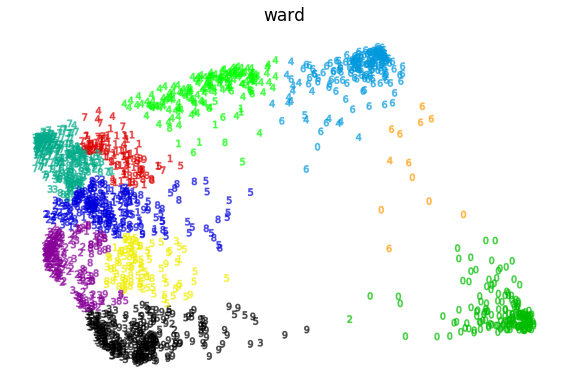

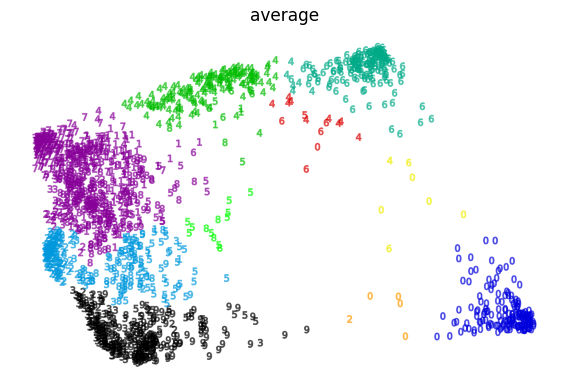

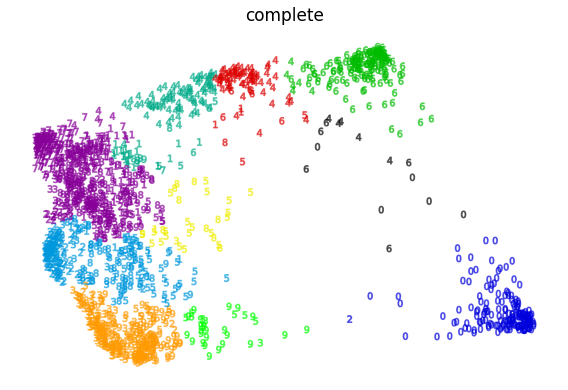

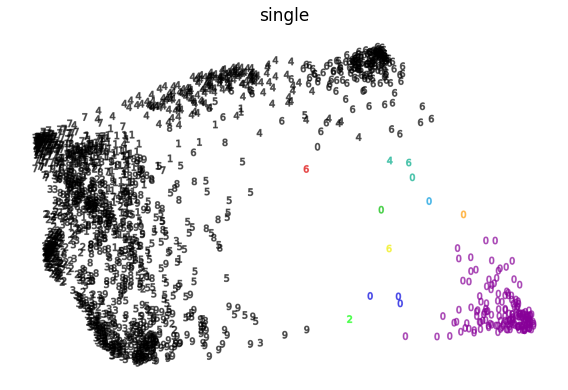

In [5]:
from sklearn.cluster import AgglomerativeClustering

for linkage in ('ward', 'average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(X_red)
    print('Spending linkage time: ', time()-t0)
    
    plot_clustering(X_red, clustering.labels_, linkage)


> 可以看到 linkage=single 相對最差，無法分出太好的分群，其是透過最小化附近的點之距離，因此分界會不夠清楚。其餘演算法在此基礎上表現較佳。

### 視覺化階層
- [參考 sklearn](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html)

In [6]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

In [7]:
def plot_dendrogram(model, **kwargs):
    """
        透過`樹狀圖(dendrogram)`查看資料分群方式。
    """
    # 每一個node底下的數量
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                # 判斷為葉節點
                current_count += 1 # leaf node
            else:
                # 判斷為非葉節點，並計算該節點有幾個子節點
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)  # 類似 np.stack，將 children, dists, counts 整併
    print(linkage_matrix.shape) #(n_samples-1, 4)
    
    dendrogram(linkage_matrix, **kwargs)
    

(1796, 4)


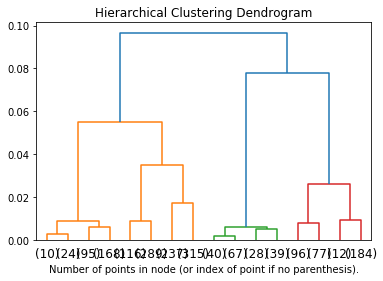

In [8]:
# iris = load_iris()
# X = iris.data #(150, 4)
# print(X.shape)
X = X_red

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None) # 因為要所有分群，因此n_clusters=None

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [9]:
## The children of each non-leaf node. 
# 代表說如果node i  >= n_samples, 就是一個非葉節點，其擁有 children[i-samples] 的子節點
model.children_ # (n_samples-1, 2)

array([[  30, 1342],
       [ 874, 1219],
       [ 707, 1710],
       ...,
       [3583, 3589],
       [3576, 3588],
       [3590, 3591]], dtype=int64)

In [10]:
## Distances between nodes in the corresponding place in children_
model.distances_  # (n_sampes-1, 1)

array([1.44707336e-06, 1.60754579e-06, 1.78937050e-06, ...,
       5.51788792e-02, 7.80046576e-02, 9.66764819e-02])